<a href="https://colab.research.google.com/github/jaeheonk817/project_surface-crack-detection/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

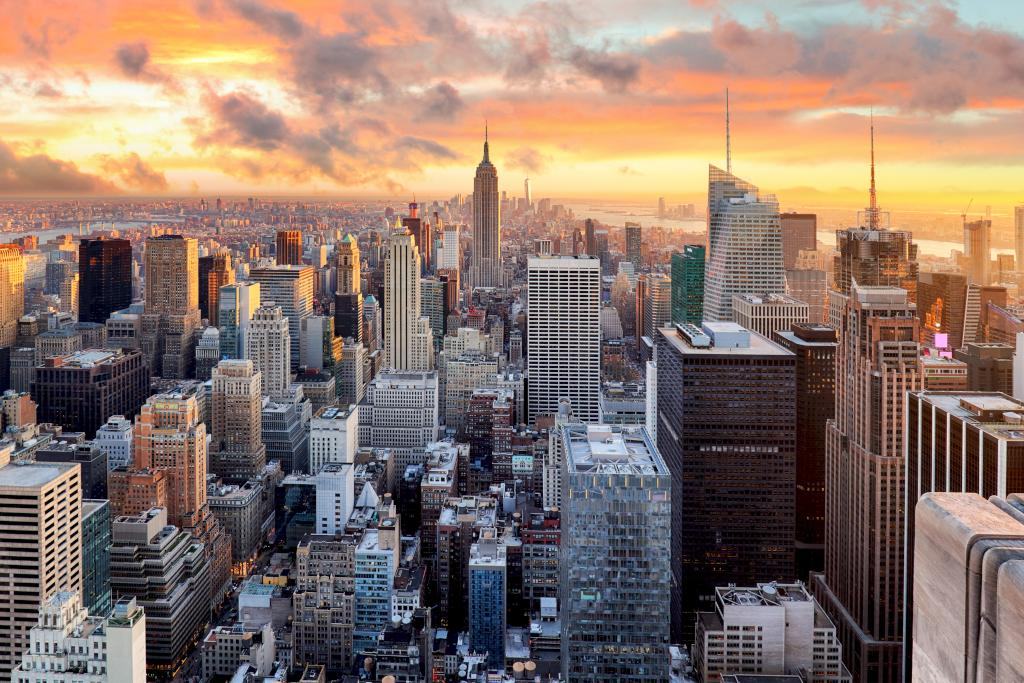

# Surface Crack Detection using CNN for NYC Department of Buildings
authored by Jae Heon Kim

## Overview
This data science project uses the CRISP-DM framework to develop a Convolutional Neural Network (CNN) model for classifying walls as either cracked or not-cracked based on image input. The project aims to provide an automated solution to identify areas for repair and maintenance in buildings. The steps involved include understanding the problem statement and defining the business goal, gathering and preparing the data, developing the model, evaluating its performance, and deploying it for use. The end result is a trained model that can accurately classify walls as cracked or not-cracked based on image input.

## Business Understanding
The stakeholder for this CRISP-DM data science project is the NYC Department of Buildings. The problem they face is that current inspection methods are outdated, costly, time-consuming, and less accurate due to human imperfections. This means that required inspections are not being completed on time, and there is a need for a more efficient and accurate solution. The stakeholder is interested in a model that can help digitize this inspection process, particularly with detecting building cracks. The goal of this project is to train a convolutional neural network (CNN) model that can accurately classify walls as cracked or not-cracked based on image input, thus providing a more automated and accurate solution for building inspections. By achieving this goal, the NYC Department of Buildings can improve the accuracy and efficiency of their inspection process, ultimately leading to cost savings and more timely inspections, which in turn can benefit and protect everyone living and working in New York City.

## Data Understanding
The dataset consists of 40,000 images of concrete surfaces with and without cracks, divided into two separate folders for negative (without crack) and positive (with crack) image classification. Each class has 20,000 images with a resolution of 227 x 227 pixels with RGB channels. The data is generated from 458 high-resolution images (4032x3024 pixel) using the method proposed by Zhang et al. (2016). No data augmentation in terms of random rotation or flipping or tilting is applied. The dataset is contributed by Çağlar Fırat Özgenel and was previously used in a study comparing the performance of pre-trained Convolutional Neural Networks (CNNs) on crack detection in buildings (Özgenel & Gönenç Sorguç, 2018). The dataset can be used for classifying crack and non-crack images and for creating a mask of the cracked portion in new images using image segmentation methods.

Source: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection


The original data was located in a single directory with two categories: positive and negative. After reviewing the data, the data was randomly split into 80% for training, 10% for validation, and 10% for testing using sklearn's train test split. Substantial portion of data was allocated to the training set due to the data's richness, which still allows for good validation and testing sets at this ratio. The process is documented in the `data_prework.ipynb` notebook, which was kept separate from the main notebook to avoid unnecessary complexity and length.


To begin, we will make necessary imports, define relevant functions, and sample some images from the data to survey both cracked and uncracked walls. This will help us get an initial understanding of the data and prepare us for further analysis.

### Imports

In [1]:
# Import basic pacakges
import numpy as np
import pandas as np

# Import visualization pacakges
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# # Import image processing packages
# from PIL import Image, ImageOps

# Import sklearn packages
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# Import tensorflow packages
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

# Import miscellaneous packesgs
import os
import random

### Functions

In [2]:
# Define a function that will save model's metrics
def save_model_metrics(model, model_name):
    """This function saves the model's metrics to a dictionary."""
    global test_data
    global model_results_dict
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Calculate accuracy, precision and recall
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)

    # Store results to the dictionary
    model_results_dict['model'].append(model_name.title())
    model_results_dict['accuracy'].append(accuracy)
    model_results_dict['precision'].append(precision)
    model_results_dict['recall'].append(recall)



# Define a function that will print model's metrics
def save_model_metrics(model, model_name):
    """This function prints the model's metrics."""
    global test_data
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Calculate accuracy, precision and recall
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)

    # Print accuracy, precision and recall
    print(f"{model_name}'s accuracy: {accuracy}")
    print(f"{model_name}'s precision: {precision}")
    print(f"{model_name}'s recall: {recall}")

### Observing Sample Data

In [8]:
# Move to the root directory
!ls

In [3]:
# Assign directory paths to negative and positive data
negative_dir = '/content/project_surface-crack-detection/data/train/negative'
positive_dir = '/content/project_surface-crack-detection/data/train/positive'

# Randomly pull fifteen negative images
negative_files = os.listdir(negative_dir)
random.shuffle(negative_files)
negative_files_random = negative_files[:15]

# Randomly pull fifteen positive images
positive_files = os.listdir(positive_dir)
random.shuffle(positive_files)
positive_files_random = positive_files[:15]

# Plot random negative images
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    image_path = os.path.join(negative_dir, negative_files_random[i])
    image = plt.imread(image_path)
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    ax[row, col].set_title(f'No Crack {i+1}')
plt.suptitle("Images of Walls - No Crack", fontsize=20, fontweight='bold')
plt.show()
print("\n"*5)

# Plot random positive images
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    image_path = os.path.join(positive_dir, positive_files_random[i])
    image = plt.imread(image_path)
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    ax[row, col].set_title(f'Crack {i+1}')
plt.suptitle("Images of Walls - Crack", fontsize=20, fontweight='bold')
plt.show()

FileNotFoundError: ignored

- Some no-crack images have patterns that the model can mis interpret as cracks.
- Some crack images have very thin cracks that the model can mistake for a lined pattern.

While most images are easily distinguishable there are some images on the borderline that are difficult to calssify.

## Data Preparation

This section aims to provide a comprehensive overview of data processing techniques that are applicable to all models. However, since we intend to perform specific data processing for each model based on the knowledge gained from the previous one, this section will be brief and straightforward. As we proceed with each model, we can explore and apply more advanced data processing techniques that are tailored to the specific requirements of the model.

### Creating Train, Validation and Test Sets

As explained in `Data Understanding` section earlier, the original data was splitted into three subsets. The work can be found in `data_prework.ipynb` in the root directory. 

### Assinging Paths to Directories

In [37]:
# Assign paths to train directories
train_negative_dir = '/content/project_surface-crack-detection/data/train/negative'
train_positive_dir = '/content/project_surface-crack-detection/data/train/positive'

# Assign paths to validation directories
val_negative_dir = '/content/project_surface-crack-detection/data/val/negative'
val_positive_dir = '/content/project_surface-crack-detection/data/val/positive'

# Assign paths to test directories
train_negative_dir = '/content/project_surface-crack-detection/data/test/negative'
train_positive_dir = '/content/project_surface-crack-detection/data/test/positive'

### Creating Image Data Generators

We will now create a simple, normalized-pixel data generator that we will use for our baseline model and possibly other models if it does well. We will instantiate a new data-generator for future models if it's necessary.

In [53]:
# Define data generator with pixel normalization
datagen = ImageDataGenerator(rescale=1./255)

## Modeling

We will finally start building models. Our baseline model will be a cnn model with a single flatten hidden layer. Subsequent models will get more complicated with fine-tuning and other techniques associated with deep-learning image processing. We will save every model and and its metrics. The metrics will be used for comparison choose a final model and we will call back on the saved final model for deployment.

### Creating Directory and Dictionary to Save Models

#### Creating Directory to Save Models

In [47]:
# # Create a directory to save models
# os.makedirs('models')

#### Creating Dictionary to Save Model Metrics

In [49]:
# Create a dictionary to store each model's results
model_results_dict = {'model':[],
                      'accuracy':[],
                      'precision':[],
                      'recall':[]}

### Baseline Model: CNN with One Hidden Layer 

## Evaluation

## Conclusion

## Next Steps